# Introduction

In today's competitive hospitality industry, understanding and improving guest satisfaction is critical for hosts, property managers, and platform administrators to maintain high occupancy rates and positive reviews.

Airbnb, as one of the leading platforms in the short-term rental market, provides a wealth of data through guest reviews. This project will implemented RoBERTa from HuggingFace’s Transformers library for sentiment analysis from review data.

The primary objective of this project is to develop a sentiment analysis pipeline capable of measuring guest satisfaction over time by analyzing sentiment from Airbnb reviews. This system will enable hosts and property managers to track changes in guest satisfaction, evaluate the effectiveness of improvements or changes made to their properties or services, and make data-driven decision-making to enhance guest experiences.

# Dataset



# Setup

## 1. Load Essential Libraries

In [1]:
# Import neccessary libraries
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## 2. Dataset

In [3]:
import gzip
import shutil
import os
import requests

# Create the 'data' directory if it doesn't exist
os.makedirs('data', exist_ok=True)

# Download the gzipped file
request = requests.get("https://data.insideairbnb.com/south-africa/wc/cape-town/2024-12-28/data/reviews.csv.gz", stream=True)

# Save and decompress simultaneously
with open("data/reviews.csv.gz", "wb") as file:
    shutil.copyfileobj(request.raw, file)

with gzip.open("data/reviews.csv.gz", "rt", encoding="utf-8") as gz_file:
    with open("data/reviews.csv", "wt", encoding="utf-8") as outfile:
        shutil.copyfileobj(gz_file, outfile)

# Exploratory Data Analysis (EDA) and Data Cleaning

### 1. Data Loading and Insepection

In [5]:
df = pd.read_csv('data/reviews.csv')  # Data loading
df.head()  # Display the first few rows

listing_id        id        date  reviewer_id reviewer_name  \
0        3191   4888238  2013-05-31      5737473      Kathleen   
1        3191   9128602  2013-12-09      8170322         Anita   
2        3191   9924130  2014-01-20      4039279         Zacki   
3        3191  16659537  2014-07-31      9729939          Doug   
4        3191  23247470  2014-11-26      9681619   Christopher   

                                            comments  
0  Great home away from home! Bridgette and Marth...  
1  Das Cottage liegt ruhig und sicher.  Wir haben...  
2  This cottage was a great base from which to ex...  
3  I had a great stay.  All my needs were well ex...  
4  Excellent host. She provided everything we cou...

In [6]:
# Get data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596775 entries, 0 to 596774
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     596775 non-null  int64 
 1   id             596775 non-null  int64 
 2   date           596775 non-null  object
 3   reviewer_id    596775 non-null  int64 
 4   reviewer_name  596774 non-null  object
 5   comments       596654 non-null  object
dtypes: int64(3), object(3)
memory usage: 27.3+ MB


## 2. Handling Missing Values

In [7]:
# Check for missing values
print(df.isnull().sum())

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      1
comments         121
dtype: int64


In [8]:
# Drop rows with missing values in 'reviewer_name' and 'comments'
df.dropna(subset=['reviewer_name', 'comments'], inplace=True)

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

## 3. Exploring Data Distributions

Identify popular listings or potential outliers.

In [9]:
df['listing_id'].value_counts()

listing_id
4646142                798
11540101               726
6711928                663
15733201               662
28656609               636
                      ... 
1314342689517475370      1
1311519999240570449      1
1311314477405304809      1
1304064818448066496      1
1303755728173709430      1
Name: count, Length: 19458, dtype: int64

Distribution of reviews over time, to identify frequent reviewers and potential biases.

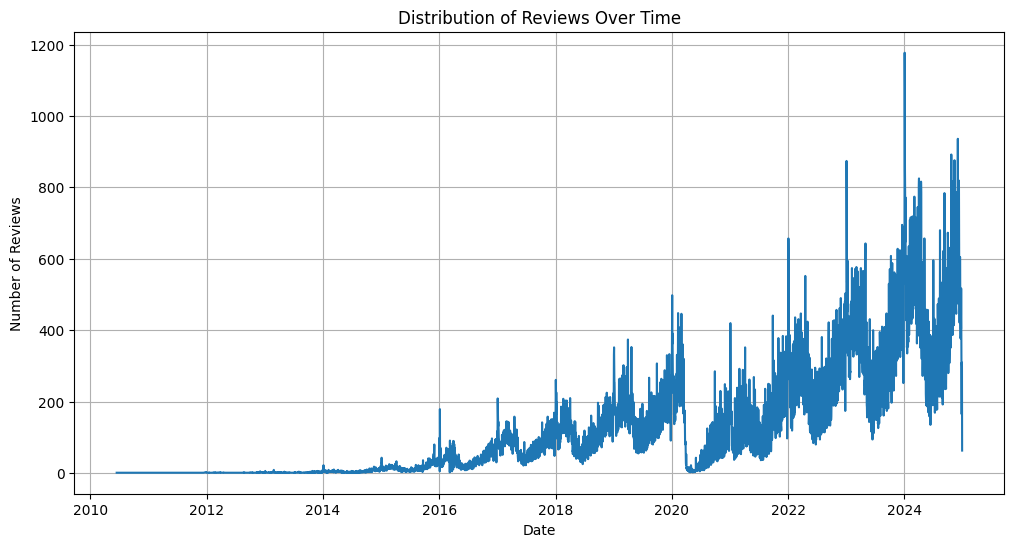

In [11]:
# Convert the 'date' column to datetime objects if it's not already
df['date'] = pd.to_datetime(df['date'])

# Group reviews by date and count them
review_counts = df.groupby('date')['listing_id'].count()

# Create a line plot of review counts over time
plt.figure(figsize=(12, 6))
plt.plot(review_counts.index, review_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews Over Time')
plt.grid(True)
plt.show()

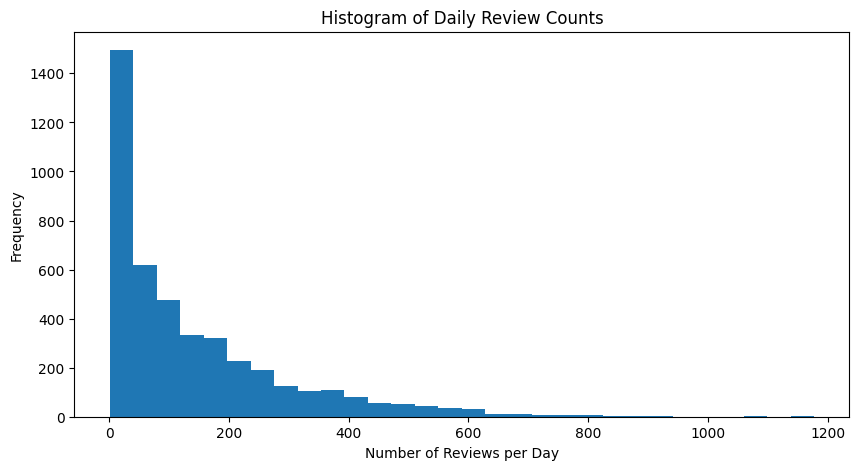

In [12]:
# Create a histogram of review counts
plt.figure(figsize=(10, 5))
plt.hist(review_counts.values, bins=30)  # Adjust 'bins' as needed
plt.xlabel('Number of Reviews per Day')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Review Counts')
plt.show()

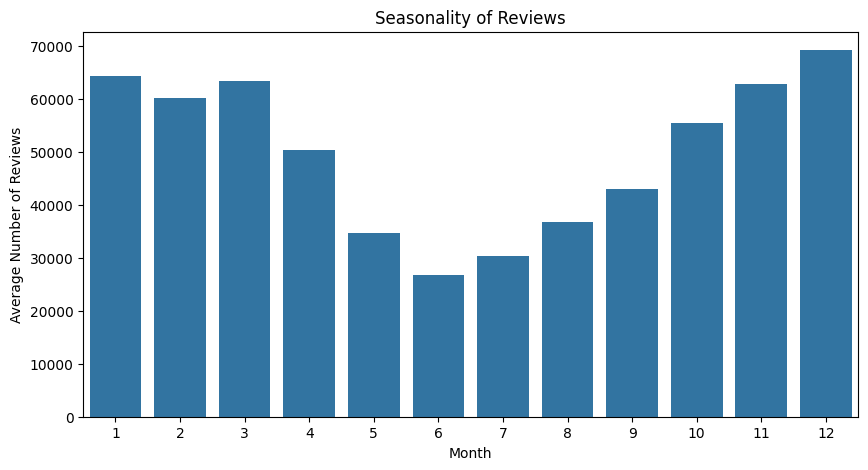

In [13]:
# Analyze for seasonality (example using monthly averages)
df['month'] = df['date'].dt.month
monthly_reviews = df.groupby('month')['listing_id'].count()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_reviews.index, y=monthly_reviews.values)
plt.xlabel('Month')
plt.ylabel('Average Number of Reviews')
plt.title('Seasonality of Reviews')
plt.show()

Analyze the length of comments

In [14]:
df['comments'].str.len()

0         125
1         263
2         203
3         118
4         163
         ... 
596648    193
596649     99
596650    180
596651     60
596652    556
Name: comments, Length: 596653, dtype: int64

# Preprocessing a Random Listing with Sufficient Reviews for Analysis

In [15]:
import random

# Minimum number of reviews required
min_reviews = 20  # Adjust as needed

# Select a random listing_id
while True:
    random_listing_id = random.choice(df['listing_id'].unique())
    filtered_reviews = df[df['listing_id'] == random_listing_id]

    # Check if the listing has enough reviews
    if len(filtered_reviews) >= min_reviews:
        break  # Exit the loop if enough reviews are found

print(f"Selected listing_id: {random_listing_id}")
print(filtered_reviews['listing_id'].value_counts())

Selected listing_id: 31684253
listing_id
31684253    61
Name: count, dtype: int64


## 1. Language Detection and Filtering Non-English Reviews

Detect and Remove Non-English Reviews

In [17]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a7dafb11b4f2f9d51d56a4c277950629aef5121196bdad5109aaeacc10b38668
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [18]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

# Set seed for reproducibility in language detection: Ensuring Consistent Results
DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        # If language detection fails, assume it's not English
        return 'unknown'

Apply Language Detection

In [21]:
# Apply Language Detection
filtered_reviews.loc[:, 'language'] = filtered_reviews['comments'].apply(detect_language)

# Display the language distribution
print(filtered_reviews['language'].value_counts())

# Filter Out Non-English Reviews
df_english = filtered_reviews[filtered_reviews['language'] == 'en']

# Reset index after filtering
df_english.reset_index(drop=True, inplace=True)

# Check the shape of the filtered dataset
print("Original dataset size:", filtered_reviews.shape)
print("Filtered dataset size:", df_english.shape)

language
en         57
unknown     1
fr          1
ca          1
de          1
Name: count, dtype: int64
Original dataset size: (61, 8)
Filtered dataset size: (57, 8)


## 2. Clean Reviews

Clean review text by removing unnecessary characters, HTML tags, URLs, and special symbols.

In [23]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  #Remove HTML tags as they might confuse the model
    text = re.sub(r'http\S+|www.\S+', '', text)   # Remove URLs
    return text

df_english.loc[:, 'cleaned_comments'] = df_english['comments'].apply(clean_text)

print(df_english[['comments', 'cleaned_comments']].sample(5))

                                             comments  \
4   What a wonderful host!, the place was very com...   
5                 Very cosy! Will definitely go again   
56  Kathy is such a warm host. We really enjoyed o...   
50  Kathy is a wonderful host. Wonderful stay with...   
54          Lovely place to stay at. Responsive host.   

                                     cleaned_comments  
4   What a wonderful host!, the place was very com...  
5                 Very cosy! Will definitely go again  
56  Kathy is such a warm host. We really enjoyed o...  
50  Kathy is a wonderful host. Wonderful stay with...  
54          Lovely place to stay at. Responsive host.  


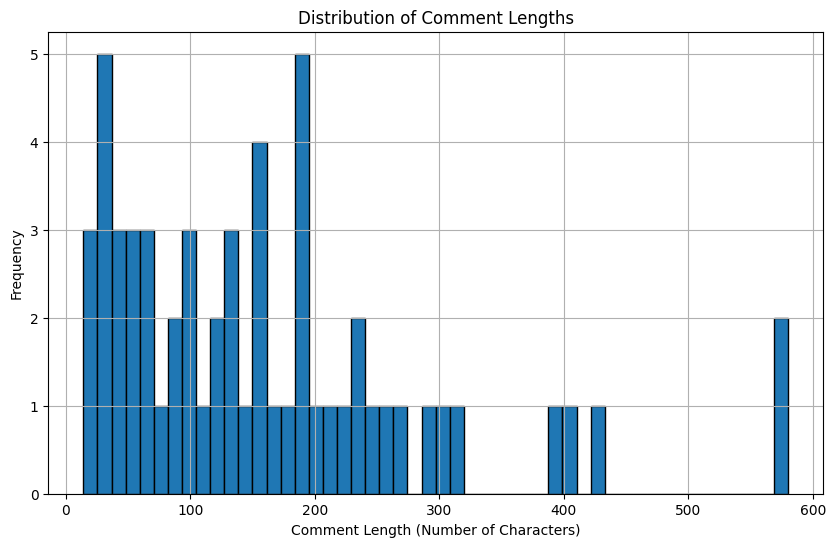

In [26]:
# Calculate comment lengths
comment_lengths = df_english['cleaned_comments'].str.len()

# Create a histogram
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.hist(comment_lengths, bins=50, edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length (Number of Characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# RoBERTa Model

In [27]:
# Import neccessary libraries

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [28]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [29]:
example = df_english['cleaned_comments'].iloc[2]
print(example)

Kathy was wonderful, super helpful and accommodating! The flatlet was beautiful and very homey. I loved the little extra touches and treats she added! If you are wondering whether you should stay here - YOU SHOULD! Thanks Kathy!


In [30]:
encoded_text = tokenizer(example, return_tensors='pt', truncation=True, padding=True, max_length=512)
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.0012952756), 'roberta_neu': np.float32(0.0060747387), 'roberta_pos': np.float32(0.99263)}


In [31]:
from tqdm import tqdm

def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt', truncation=True, padding=True, max_length=512)
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [32]:
results = {}
for i, row in tqdm(df_english.iterrows(), total=len(df_english)):
  try:
    text = row['cleaned_comments']
    myid = row['id']

    # RoBERTa Sentiment Analysis
    roberta_result = polarity_scores_roberta(text)

    # Storing Results
    results[myid] = roberta_result
  except RuntimeError:
    print(f'Broke for id {myid}')

100%|██████████| 57/57 [00:10<00:00,  5.34it/s]


In [33]:
results_df = pd.DataFrame(results).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = filtered_reviews.merge(results_df, how='left')

In [34]:
results_df.head()

listing_id         id       date  reviewer_id reviewer_name  \
0    31684253  408697726 2019-02-05    238927588       Luyanda   
1    31684253  415210700 2019-02-22    238235631        Martin   
2    31684253  418463998 2019-03-02    117143320     Dominique   
3    31684253  421898855 2019-03-10    234794453      Zimkhita   
4    31684253  431020595 2019-03-31    214443974         Akona   

                                            comments  month language  \
0  My wife and I had a wonderful and comfortable ...      2       en   
1                   Clean, stylish and cozy and more      2       en   
2  Kathy was wonderful, super helpful and accommo...      3       en   
3  We had a wonderful weekend with my husband. Th...      3       en   
4  What a wonderful host!, the place was very com...      3       en   

   roberta_neg  roberta_neu  roberta_pos  
0     0.001453     0.006404     0.992144  
1     0.002668     0.067145     0.930188  
2     0.001295     0.006075     0.992630  
3     0.001658     0.004638     0.993705  
4     0.001421     0.005955     0.992624

# Results

## 1. Visualize guest satisfaction trends

### Year Averages

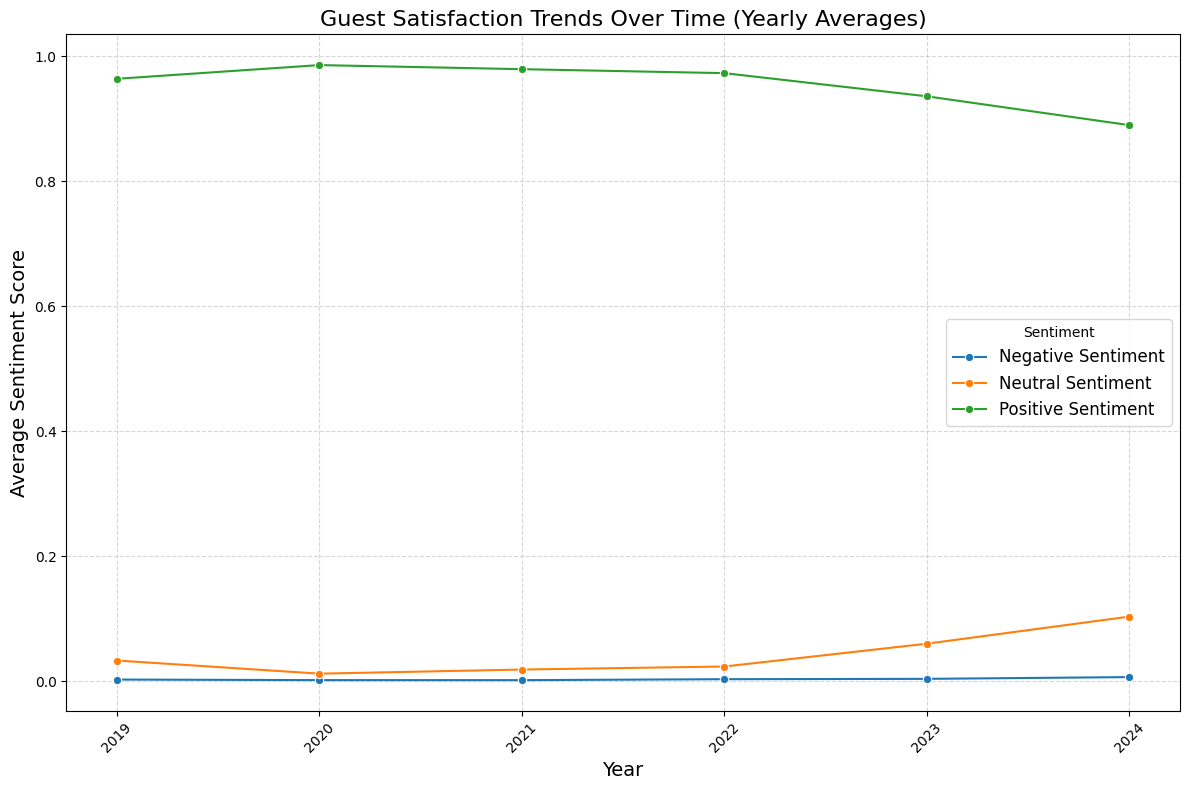

In [35]:
# Group by year and calculate the mean sentiment scores
yearly_sentiment = results_df.groupby(results_df['date'].dt.year)[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=yearly_sentiment.index, y=yearly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Yearly Averages)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(yearly_sentiment.index, rotation=45)  # Show all years on x-axis and rotate for readability
plt.legend(title='Sentiment', fontsize=12) # Add legend title
plt.grid(True, linestyle='--', alpha=0.5) # Add grid for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

### Quaterly Averagas

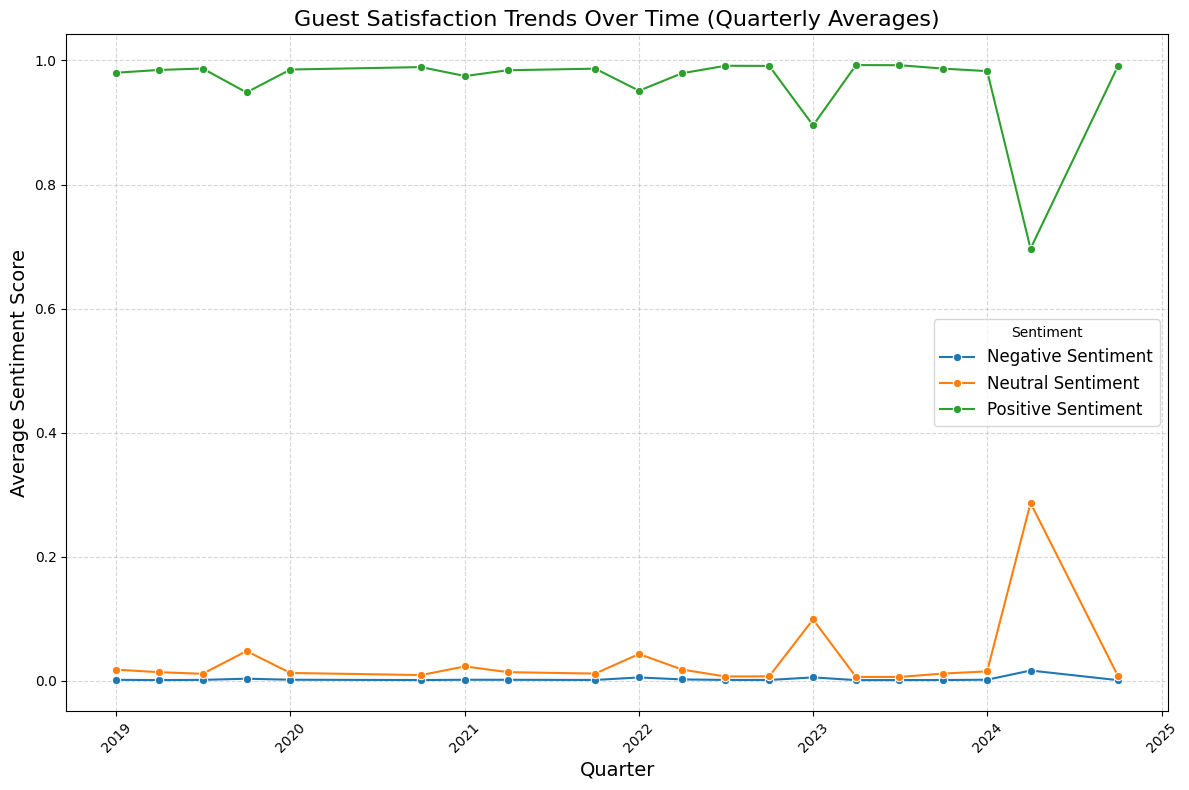

In [36]:
# Group by quarter and calculate the mean sentiment scores
quarterly_sentiment = results_df.groupby(results_df['date'].dt.to_period('Q'))[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=quarterly_sentiment.index.to_timestamp(), y=quarterly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=quarterly_sentiment.index.to_timestamp(), y=quarterly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=quarterly_sentiment.index.to_timestamp(), y=quarterly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Quarterly Averages)', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Monthly Averages

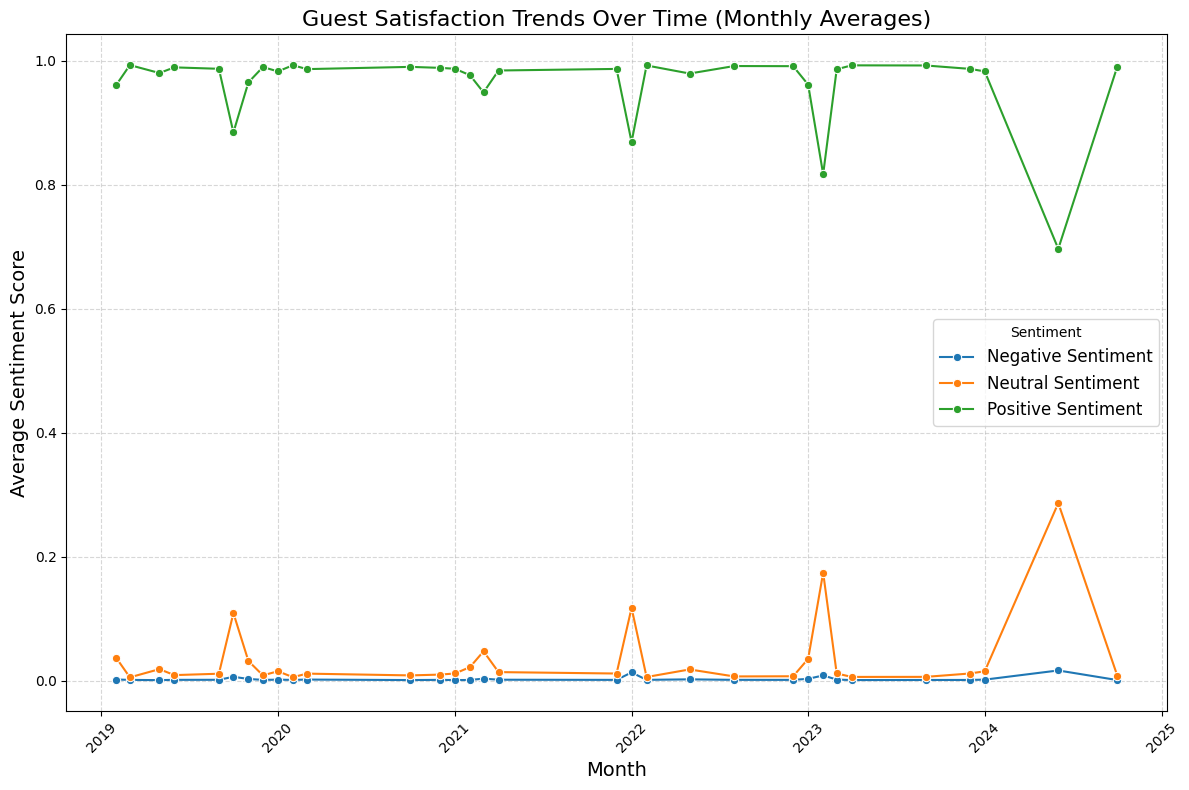

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by month and calculate the mean sentiment scores
monthly_sentiment = results_df.groupby(results_df['date'].dt.to_period('M'))[['roberta_neg', 'roberta_neu', 'roberta_pos']].mean()

plt.figure(figsize=(12, 8))

# Plot negative sentiment
sns.lineplot(x=monthly_sentiment.index.to_timestamp(), y=monthly_sentiment['roberta_neg'], label='Negative Sentiment', marker='o')

# Plot neutral sentiment
sns.lineplot(x=monthly_sentiment.index.to_timestamp(), y=monthly_sentiment['roberta_neu'], label='Neutral Sentiment', marker='o')

# Plot positive sentiment
sns.lineplot(x=monthly_sentiment.index.to_timestamp(), y=monthly_sentiment['roberta_pos'], label='Positive Sentiment', marker='o')

plt.title('Guest Satisfaction Trends Over Time (Monthly Averages)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Sentiment Score', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()